##使用预训练CNN进行迁移学习

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:
import os
os.chdir('/content/drive/My Drive/data')
!pwd

/content/drive/My Drive/data


在本教程中，我们将讨论如何使用预训练网络中的转移学习对猫与狗图像进行分类。通过从头开始训练我们的网络，我们可以获得比我们看到的更高的准确度。

一个**预先训练模型**是以前训练的大型数据集，通常在大型图像分类任务保存的网络。我们既可以使用预训练模型，也可以使用预训练的修道院进行学习。**转移学习**背后的直觉是，如果这个模型在一个足够大且通用的数据集上训练，这个模型将有效地作为视觉世界的通用模型。我们可以利用这些学到的特征映射，而无需在大型数据集上训练大型模型，方法是使用这些模型作为我们自己的特定于我们任务的模型的基础。使用预训练模型有两种转移学习方案：

  1. **特征提取** - 使用先前网络学习的表示从新样本中提取有意义的特征。我们只是在预训练模型的基础上添加一个新的分类器，它将从头开始训练，这样我们就可以重新利用先前为我们的数据集学习的特征图。**我们使用整个预训练模型还是只使用卷积基数？** - 我们使用这些预训练的网络（卷积基数）的特征提取部分，因为它们可能是图片上的通用特征和学习概念。然而，预训练模型的分类部分通常特定于原始分类任务，并且随后特定于训练模型的类集。
  2. **微调** - 解冻用于特征提取的冻结模型基础的一些顶层，并联合训练新添加的分类器层以及冻结模型的最后层。除了我们的最终分类器之外，这允许我们“微调”高阶特征表示，以使它们与所涉及的特定任务更相关。

###我们将遵循一般的机器学习工作流程：

   1. 检查并理解数据
  2. 构建输入管道 - 使用Keras ImageDataGenerator，就像我们在图像分类教程中所做的那样
  3. 撰写我们的模型
      - 加载我们的预训练模型（和预训练的重量）
      - 将我们的分类图层堆叠在顶部
  4. 训练我们的模型
  5. 评估模型
  
我们将看到一个使用预训练的convnet作为特征提取的示例，然后进行微调以训练基础模型的最后几层。

**观众**：这篇文章面向具有一些Keras API和ML背景的初学者。为了充分利用这篇文章，你应该有一些基本的ML背景，知道CNN是什么，并熟悉Keras Sequential API。

**估计时间**：30分钟

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


##数据预处理
下载数据 - cats_and_dogs_filtered.zip

我们将下载Kaggle's [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data)数据集的过滤版本。然后将下载的zip文件存储到“/ tmp /”目录中。

In [0]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [0]:
base_dir = os.path.join('.','cats_and_dogs_small')
base_dir

'./cats_and_dogs_small'

###准备训练和验证猫狗数据集
为猫数据集和狗数据集创建训练和验证目录。

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print("Total training cat images:", len(os.listdir(train_cats_dir)))


#Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print("Total training dog images:", len(os.listdir(train_dogs_dir)))



#Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print("Total validation cat images:", len(os.listdir(validation_cats_dir)))


#Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print("Total validation dog images:", len(os.listdir(validation_dogs_dir)))



Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


###使用图像增强创建图像数据生成器
我们将使用ImageDataGenerator重新缩放图像。

要创建列车生成器，请指定列车数据集目录，图像大小，批量大小和二进制分类模式的位置。

验证生成器以相同的方式创建。

In [0]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

#Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 20 using train_datagen gernerator
train_generator = train_datagen.flow_from_directory(train_dir,# Source directory for the training images
                                                   target_size=(image_size,image_size),
                                                   batch_size=batch_size,
                                                   #Since we use binary_crossentropy loss, we need binary labels
                                                   class_mode='binary')


#Flow validation images in batches of 20 using validation_datagen gernerator
validation_generator = validation_datagen.flow_from_directory(validation_dir,# Source directory for the validation images
                                                   target_size=(image_size,image_size),
                                                   batch_size=batch_size,
                                                   #Since we use binary_crossentropy loss, we need binary labels
                                                   class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


###从预先训练的网络中创建基础模型
我们将从Google开发的**MobileNet V2**模型创建基础模型，并在ImageNet数据集上进行预训练，这是一个包含1.4M图像和1000类Web图像的大型数据集。这是一个强大的模型。让我们看看它学到的功能可以为我们的猫与狗问题做些什么。

首先，我们需要选择我们将用于特征提取的MobileNet V2中间层。通常的做法是在展平操作之前使用最后一层的输出，即所谓的“瓶颈层”。这里的理由是，以下完全连接的层对于网络训练的任务而言过于专业化，因此这些层学到的特征对于新任务将不是非常有用。然而，瓶颈特征保持了很多普遍性。

让我们实例化预装了ImageNet上训练的权重的MobileNet V2模型。通过指定**include_top = False**参数，我们加载了一个不包含顶部分类图层的网络，这是特征提取的理想选择。

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

W0905 09:28:29.679068 140110648407936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


9412608/9406464 [==============================] - 1s 0us/step


##特征提取
我们将冻结从上一步创建的卷积基，并将其用作特征提取器，在其上添加分类器并训练顶级分类器。

###冻结卷积基数
在编译和训练模型之前，冻结卷积是很重要的。通过冻结（或设置`layer.trainable = False`），我们可以防止在训练期间更新这些层中的权重。

In [0]:
base_model.trainable = False

In [0]:
#Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

###添加分类头
现在让我们在基础模型的顶部添加几个层：

In [0]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

##编译模型
您必须在训练之前编译模型。

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

W0905 09:35:51.261085 140110648407936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


这些1.2K可训练参数分为2个TensorFlow Variable对象，两个密集层的权重和偏差：

In [0]:
len(model.trainable_variables)

2

##训练模型
经过10个时期的训练，我们可以获得约94％的准确率。

如果你有更多的时间，训练它收敛（50个时代，准确率约96％）

In [0]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=epochs,
                             workers=4,
                             validation_data=validation_generator,
                             validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 220s 4s/step - loss: 0.5925 - acc: 0.6911 - val_loss: 0.4924 - val_acc: 0.7883
Epoch 2/10
62/62 [==============================] - 12s 190ms/step - loss: 0.4872 - acc: 0.7790 - val_loss: 0.3883 - val_acc: 0.8468
Epoch 3/10
62/62 [==============================] - 12s 189ms/step - loss: 0.4214 - acc: 0.8283 - val_loss: 0.3264 - val_acc: 0.8810
Epoch 4/10
62/62 [==============================] - 12s 192ms/step - loss: 0.3712 - acc: 0.8496 - val_loss: 0.2785 - val_acc: 0.9002
Epoch 5/10
62/62 [==============================] - 12s 190ms/step - loss: 0.3349 - acc: 0.8750 - val_loss: 0.2427 - val_acc: 0.9133
Epoch 6/10
62/62 [==============================] - 12s 190ms/step - loss: 0.3026 - acc: 0.8938 - val_loss: 0.2332 - val_acc: 0.9133
Epoch 7/10
62/62 [==============================] - 12s 191ms/step - loss: 0.2818 - acc: 0.8984 - val_loss: 0.2179 - val_acc: 0.9143
Epoch 8/10
62/62 [==============================] - 12s 192ms/step - lo

###学习曲线
当使用MobileNet V2基础模型作为固定特征提取器时，让我们看一下训练和验证准确度/损失的学习曲线。

如果训练到convergence（`epochs=50`），结果图应如下所示：

![图片](https://www.tensorflow.org/tutorials/images/images/before_fine_tuning.png)

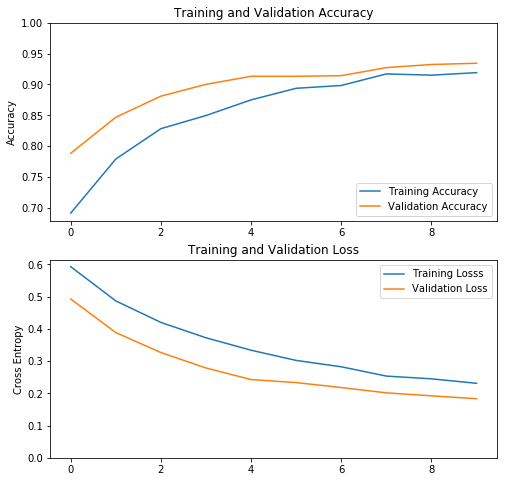

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Losss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


##微调
在我们的特征提取实验中，我们只在MobileNet V2基础模型上训练了几层。训练期间未预先更新预训练网络的权重。进一步提高性能的一种方法是在顶级分类器的训练的同时“微调”预训练模型的顶层的权重。训练过程将强制将权重从通用要素图调整为专门与我们的数据集关联的要素。

>注意：只有在训练顶级分类器并将预训练模型设置为不可训练后，才应尝试此操作。如果您在预先训练的模型上添加一个随机初始化的分类器并尝试联合训练所有图层，则渐变更新的幅度将太大（由于分类器的随机权重），并且您的预训练模型将忘记它所学到的一切。

另外，微调预训练模型的顶层而不是预训练模型的所有层的原因如下：在一个网络中，一层越高，它就越专业化。回旋网中的前几层学习了非常简单和通用的特征，这些特征可以推广到几乎所有类型的图像。但是随着您越来越高，这些功能越来越多地针对模型所训练的数据集。微调的目标是使这些专用功能适应新数据集。

###取消冻结模型的顶层
我们需要做的就是解冻`base_model`，并将底层设置为无法训练。然后，重新编译模型（这些更改生效所必需的），并恢复培训。

In [0]:
base_model.trainable = True

In [23]:
#Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

#Fine tune from this layer onwards
fine_tune_at = 100

#Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 155


###编译模型
使用低得多的训练率编译模型。

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [26]:
len(model.trainable_variables)

58

###继续训练模型
如果您之前接受过融合训练，这将使您的准确度提高几个百分点。

In [27]:
history_fine = model.fit_generator(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  workers=4,
                                  validation_data=validation_generator,
                                  validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 18s 297ms/step - loss: 0.1633 - acc: 0.9446 - val_loss: 0.0971 - val_acc: 0.9647
Epoch 2/10
62/62 [==============================] - 13s 203ms/step - loss: 0.0868 - acc: 0.9776 - val_loss: 0.0876 - val_acc: 0.9647
Epoch 3/10
62/62 [==============================] - 13s 203ms/step - loss: 0.0638 - acc: 0.9797 - val_loss: 0.0804 - val_acc: 0.9677
Epoch 4/10
62/62 [==============================] - 13s 202ms/step - loss: 0.0502 - acc: 0.9878 - val_loss: 0.0823 - val_acc: 0.9688
Epoch 5/10
62/62 [==============================] - 13s 208ms/step - loss: 0.0305 - acc: 0.9914 - val_loss: 0.0838 - val_acc: 0.9667
Epoch 6/10
62/62 [==============================] - 13s 204ms/step - loss: 0.0237 - acc: 0.9975 - val_loss: 0.1006 - val_acc: 0.9637
Epoch 7/10
62/62 [==============================] - 13s 206ms/step - loss: 0.0145 - acc: 0.9980 - val_loss: 0.0902 - val_acc: 0.9657
Epoch 8/10
62/62 [==============================] - 13s 205ms/step - 

##学习曲线
让我们看一下培训和验证准确度/损失的学习曲线，微调MobileNet V2基础模型的最后几层，以及它上面的分类器。注意验证损失远高于训练损失，这意味着可能有一些过度拟合。

注意：训练数据集相当小，类似于MobileNet V2训练的原始数据集，因此微调可能会导致过度拟合。

如果训练到convergence（`epochs=50`），结果图应如下所示：

---

![图片](https://www.tensorflow.org/tutorials/images/images/fine_tuning.png)

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

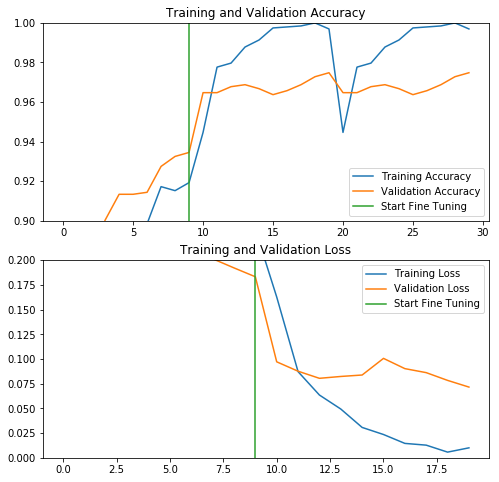

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.ylim([0.9,1])
plt.plot([epochs-1,epochs-1],plt.ylim(),label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,0.2])
plt.plot([epochs-1,epochs-1],plt.ylim(),label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##关键要点
总之，这里是我们在本教程中介绍的如何使用预先训练的模型进行传递学习以提高准确性：* 使用预先训练的模型进行**特征提取** - 使用小型数据集时，通常会利用通过在同一域中的较大数据集上训练的模型学习的特征。这是通过实例化预训练模型并在顶部添加完全连接的分类器来完成的。预训练的模型被“冻结”，并且在训练期间仅更新分类器的权重。在这种情况下，卷积基础提取与每个图像相关联的所有特征，并且我们训练分类器，该分类器在给定这些特征集的情况下确定它属于哪个类。*  **微调**预先训练的模型 - 为了进一步提高性能，人们可能希望通过微调将预训练模型的顶层重新调整到新数据集中。在这种情况下，我们调整权重，以便我们学习特定于数据集的高度指定和高级特征。这仅在训练数据集很大且与预训练模型训练的原始数据集非常相似时才有意义。